In [1]:
import numpy as np

class PCA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, X):
        # mean centering
        self.mean = np.mean(X, axis=0)
        X = X -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(X.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, X):
        # projects data
        X = X - self.mean
        return np.dot(X, self.components.T)

In [1]:
import pickle

# Load the list from the file using pickle
with open("dataset.pkl", "rb") as f:
    my_list = pickle.load(f)


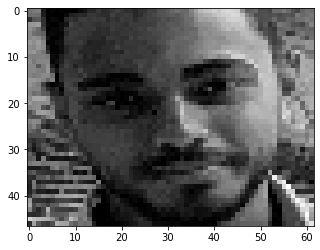

In [2]:
import matplotlib.pyplot as plt
import cv2

# Get a random image from the dataset
sample_image = my_list[0][18]
sample_image = sample_image.reshape(47,62)
# Display the image

plt.imshow(sample_image, cmap='gray')
plt.show()

In [3]:
X , y , names = my_list

In [4]:
import numpy as np

In [5]:
X = np.array(X)

In [6]:
print(X.shape)

(218, 2914)


In [7]:
import numpy as np
from sklearn import  metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm

In [8]:
# Apply PCA to the raw pixel values
n_components = 100
pca = PCA(n_components=n_components)
eigenfaces = pca.fit(X)
eigenfaces = pca.transform(X)

In [9]:
eigenfaces.shape

(218, 100)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(eigenfaces, y, test_size=0.1,random_state=42)


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Assuming X_train and y_train are your training data and target variable
# Define the parameter grid for the SVM classifier
parameters = {'kernel' : ('poly', 'rbf','linear'), 'C':[0.01, 0.1, 0.5, 1, 10]}


# Create the SVM classifier with an RBF kernel
clf = SVC(kernel='rbf')

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf, parameters, cv=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best value of C found by GridSearchCV
print("Best kernel :", grid_search.best_params_['kernel'])
print("Best C value found:", grid_search.best_params_['C'])

Best kernel : linear
Best C value found: 0.01


In [22]:
# Train an SVM model using the training set
clf = SVC(kernel='linear', C=0.01)
# clf = svm.LinearSVC(C=0.01)
clf.fit(X_train, y_train)


SVC(C=0.01, kernel='linear')

In [23]:
y_pred = clf.predict(X_test)


In [24]:
# Evaluate the performance of the model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")

Accuracy: 0.8181818181818182
Precision: 0.7175324675324675
Recall: 0.8181818181818182
F1 score: 0.7617382617382618


C:\Users\A\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
import cv2

def predict_image(path,model,pca,names):
    # Load the pre-trained face detection classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Set the new width and height
    # new_width = 500
    # new_height = 500

    img = cv2.imread(path)

    # Resize the image
    # resized_img = cv2.resize(img, (new_width, new_height))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=5)
    max = 0
    for i in range(len(faces)):
        if faces[i][2] * faces[i][3] > max:
            max = faces[i][2] * faces[i][3]
            real_face = faces[i]

    x, y, w, h =  real_face
    cropped_img = gray[y:y+h, x:x+w]

    cropped_img = cv2.resize(cropped_img,(62, 47))
    flatten_img = cropped_img.flatten().reshape(1,-1)
    flatten_img = pca.transform(flatten_img)
    result = model.predict(flatten_img)
    confidence = model.decision_function(flatten_img)

    # Print the prediction and confidence
    print("Prediction:", names[int(result)])
    print("Confidence:", confidence)

In [351]:
from sklearn import metrics
import matplotlib.pyplot as plt
#split the dataset into training (70%) and testing (30%) sets


#define metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ValueError: multiclass format is not supported

In [100]:
predict_image('C:/Users/A/Pictures/Camera Roll/13.jpg',clf,pca,names)

Prediction: mahmoud
Confidence: [[ 3.22632986 -0.24409621  4.28744809  1.76999186  0.74211155]]


In [354]:
with open('trained_model.pkl', 'wb') as f:
    pickle.dump((pca, clf,names), f)

In [189]:
import pickle

# Load the saved model from the file
with open('trained_model.pkl', 'rb') as f:
    pca, clf ,names= pickle.load(f)
